## Face Detection and creation of training and validiation data-sets
To detect faces in our images we utilize two of dlibs pretrained face detector models. 
* A objected detector based on HOG filters: dlib.get_frontal_face_detector 
* A pretrained CNN Model for face detection downloaded from http://dlib.net/files/mmod_human_face_detector.dat.bz2
<br> 

Note: We ended up not using the pretrained CNN model due to high memory demands and computationally costs

In [11]:
# Download and unzip the model
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2;
!bunzip2 mmod_human_face_detector.dat.bz2;

--2018-03-03 15:05:53--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net... 107.180.26.78
Connecting to dlib.net|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: 'mmod_human_face_detector.dat.bz2'

mmod_human_face_det 100%[===================>] 678.43K  1.02MB/s    in 0.7s    

2018-03-03 15:05:54 (1.02 MB/s) - 'mmod_human_face_detector.dat.bz2' saved [694709/694709]



In [1]:
# import the necessary libraries
import numpy as np
from PIL import Image
import dlib
from pathlib import Path
from tqdm import tqdm
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
root = Path('./') # define root path
data_path = Path('data') # define data path
data_path.mkdir(exist_ok=True, parents=True) 
extracted_faces_path = data_path.joinpath('Extracted_faces')
extracted_faces_path.mkdir(exist_ok=True, parents=True) 
extracted_faces_from_group_path = data_path.joinpath('Extracted_faces_from_group') # manually labelled

pretrained_cnn_detector = root.joinpath('mmod_human_face_detector.dat') # define pretrained cnn model path
raw_path = data_path.joinpath('raw')
much_face_path = data_path.joinpath('much_face')

In [15]:
if mmod_hfd_path.is_file() == False:
    print('please download mmod_human_face_detector.dat from http://dlib.net/files/mmod_human_face_detector.dat.bz2 and unzip in current directory')
else:
    pass


In [3]:
# create face detectors from dlib
hog_face_detect = dlib.get_frontal_face_detector()
cnn_face_detect = dlib.cnn_face_detection_model_v1(str(pretrained_cnn_detector.absolute()))

In [129]:
def load_image(file):
    """
    load file and return it as a numpy array 
    """
    img = Image.open(file)
    # We add this helper function to account for the iPhone SE quirk as explained in later sections
    try:
        if str(img.info['exif']).find('iPhone SE') != -1:
            img = img.rotate(-90,expand=1)
            return np.array(img)
        else:
            return np.array(img)
    except:
        print('Exception thrown in img.info, continuing without check for iPhone SE')
        return np.array(img)

def face_detect(img,detector='hog',num_times_upsample=1):
    """
    img: numpy array 
    detector: 'hog' or 'cnn' (default: hog)
    num_times_upsample: upsampling makes the image bigger and allows for smaller faces to be detected (default: 1)
    returns bounding boxes
    """
    if detector == 'hog':
        return hog_face_detect(img,num_times_upsample)
    if detector == 'cnn':
        return cnn_face_detect(img,num_times_upsample)
    else:
        raise ValueError('Invalid detector selected. Valid options: hog,cnn') 

The bounding box is returned in the format [(left,top) (right,bottom)] <br>
Illustrations from https://stackoverflow.com/questions/22589322/what-does-top-left-right-and-bottom-mean-in-android-rect-object 
![](lefttoprightbottom.png)
![](lefttoprightbottom2.png)

### Detect all faces in an image, extract and save them to disk to generate training images for our classifier

In [5]:
def delib_rec_to_tuple(rec):
    """
    convert dlib rectangle object to standard python tuple
    """
    left = rec.left()
    right = rec.right()
    top = rec.top()
    bottom = rec.bottom()
    return (left,top,right,bottom)

In [6]:
def face_extractor(image,outputpath,num_times_upsample=1,detector='hog'):
    """
    image: RGB image (e.g. /path/image.jpg )
    outputpah: PosixPath
    detector: hog or cnn
    input image needs padding if faces are too close to boarder
    e.g. implement: https://docs.opencv.org/3.4.0/dc/da3/tutorial_copyMakeBorder.html
    """
    image_filename = str(image).split('/')[-1].split('.')[-2]
    numpyimage = load_image(image)
    face_bboxes = face_detect(numpyimage,detector,num_times_upsample)
    outputpath = outputpath.absolute()
    
    for counter,f in enumerate(face_bboxes):
        try:
            left,top,right,bottom = delib_rec_to_tuple(f) # get coordinates as shown above
            face = Image.fromarray(numpyimage[top:bottom,left:right]) # create pillow image
            fullname = '{}/{}_{}.jpg'.format(outputpath,image_filename,counter) # file path
            face.save(fullname,format='JPEG') # save as jpg
        except:
            print('bounding box outside of image')

Test the face extractor, commented out after sucessfull testing

In [7]:
#face_extractor('indiv.jpg',extracted_faces_path)

### Loop through all folders of individuals and extract the faces

In [7]:
raw_path

PosixPath('data/raw')

In [88]:
# for testing
# production raw path = 'data/raw'
# raw_path = data_path.joinpath('raw_test')

In [69]:
# utilize iterdir 
pattern = '*.JPG' # check for jpgs only (do two rounds one with jpg one with JPG)
for child in raw_path.iterdir(): 
    if str(child).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store file
        pass
    else:
        for image in tqdm(child.glob(pattern)):
            outputsubfolder = str(child.absolute()).split('/')[-1] # get the folder name (e.g. 001)
            outputpath = extracted_faces_path.joinpath(outputsubfolder)
            outputpath.mkdir(exist_ok=True, parents=True) # create new output path 
            face_extractor(image,outputpath,num_times_upsample=1) # extract faces and save to disk

10it [00:45,  4.52s/it]
12it [00:55,  4.62s/it]
6it [00:06,  1.03s/it]
12it [00:48,  4.01s/it]
10it [00:40,  4.00s/it]
7it [00:07,  1.02s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
7it [00:09,  1.32s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
4it [00:05,  1.33s/it]
0it [00:00, ?it/s]
4it [00:04,  1.02s/it]
12it [00:52,  4.34s/it]
11it [00:46,  4.19s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
10it [00:39,  3.98s/it]
10it [00:40,  4.03s/it]
4it [00:04,  1.09s/it]
4it [00:05,  1.37s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
12it [00:48,  4.02s/it]
0it [00:00, ?it/s]
12it [00:48,  4.04s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
7it [00:07,  1.02s/it]
0it [00:00, ?it/s]
6it [00:07,  1.25s/it]
7it [00:08,  1.25s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
4it [00:06,  1.61s/it]
9it [00:43,  4.79s/it]
10it [00:42,  4.26s/it]
10it [00:45,  4.53s/it]
4it [00:05,  1.35s/it]
0it [00:00, ?it/s]
0it [00:00, ?i

## Extract frames from mov (HVEC) Videos
opencv doc:
https://docs.opencv.org/3.4.0/dd/d43/tutorial_py_video_display.html

In [116]:
def frames_from_vid(video,outputpath):
    video_filename = str(video).split('/')[-1].split('.')[-2]
    cap = cv2.VideoCapture(video)
    caplength = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    counter = 0
    outputpath = outputpath.absolute()
    while cap.isOpened(): 
        ret, frame = cap.read()
        if ret == True:
            fullname = '{}/{}_{}.jpg'.format(outputpath,video_filename,counter) # file path
            cv2.imwrite(fullname,frame)
            counter +=1
        else:
            break
    cap.release()

### Examine images
Faces from class group photo were sorted manually into their corresponding subdirectory

In [142]:
# Count how many images we have per individum
# we are only interested in jpgs
pattern = "*.jpg"
face_from_group_folder_file = []
for folder in extracted_faces_from_group_path.iterdir():
    if str(folder).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store folder
        pass
    else:
        for file in folder.glob(pattern): 
            face_from_group_folder_file.append((str(folder).split('/')[-1],file))
            
            
faces_from_individual_folder_file = []
for folder in extracted_faces_path.iterdir():
    if str(folder).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store folder
        pass
    else:
        for file in folder.glob(pattern): 
            faces_from_individual_folder_file.append((str(folder).split('/')[-1],file))
            
much_face_folder_file = []
for folder in much_face_path.iterdir():
    if str(folder).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store folder
        pass
    else:
        for file in folder.glob(pattern): 
            much_face_folder_file.append((str(folder).split('/')[-1],file))
            

In [138]:
df_face_from_group_folder_file = pd.DataFrame(face_from_group_folder_file)
df_faces_from_individual_folder_file = pd.DataFrame(faces_from_individual_folder_file)
df_much_face_folder_file = pd.DataFrame(much_face_folder_file)

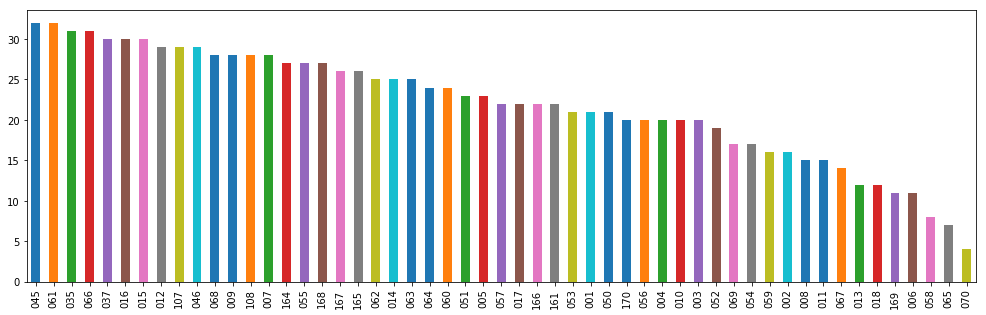

In [139]:
# plotting the number of extracted faces from the class photo per individual
df_face_from_group_folder_file[0].value_counts().plot(kind='bar',figsize=(17,5))

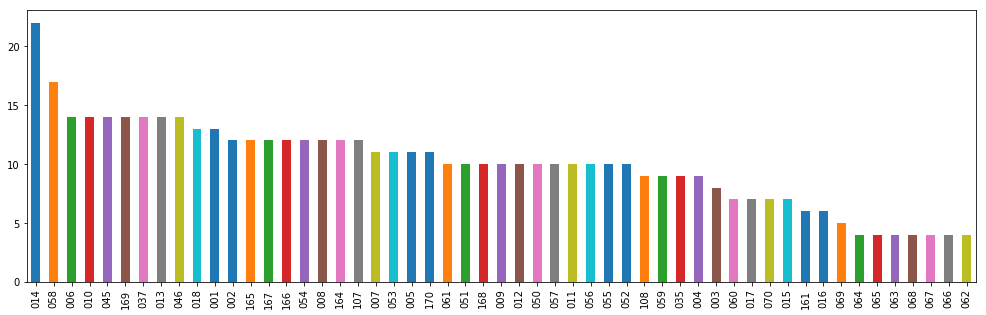

In [137]:
# plotting the number of extracted faces from the individual photos
df_faces_from_individual_folder_file2 = df_faces_from_individual_folder_file[df_faces_from_individual_folder_file[0] != 'Group']
df_faces_from_individual_folder_file2[0].value_counts().plot(kind='bar',figsize=(17,5))

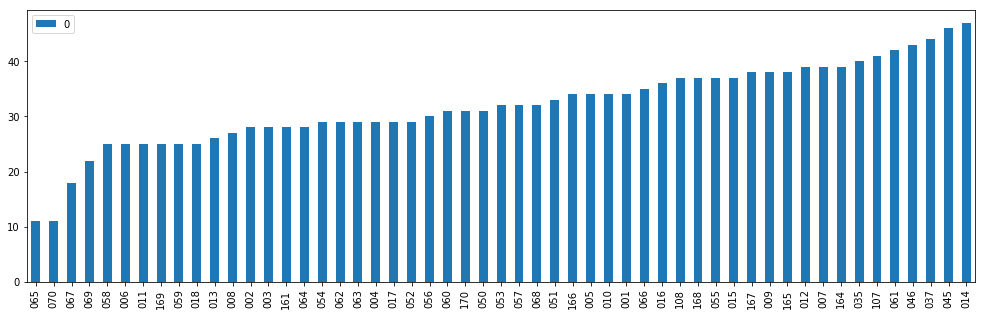

In [143]:
# combined count
df1 = pd.DataFrame(df_faces_from_individual_folder_file2[0].value_counts())
df2 = pd.DataFrame(df_face_from_group_folder_file[0].value_counts())
df3 = df1 + df2
df3.sort_values(by=0).plot(kind='bar',figsize=(17,5))

In [112]:
# total number of faces (excluding video)
df3.sum()[0]

1673

Overall the dataset is relatively balanced, for those individuals where less than 25 images are available, additional images were extracted from the available video files in .mov format. For four individuals, 065,070,067 and 069 no video was available as shown in the Figure above.

In [117]:
frames_from_vid_path = data_path.joinpath('Frames_from_vid')

In [124]:
vid1_058 = raw_path.joinpath('058/IMG_0302.mov')
vid2_058 = raw_path.joinpath('058/IMG_0301.mov')
vid3_058 = raw_path.joinpath('058/IMG_0295.mov')
vid1_018 = raw_path.joinpath('018/IMG_0076.mov')
vid2_018 = raw_path.joinpath('018/IMG_0079.mov')
vid1_169 = raw_path.joinpath('169/IMG_0328.mov')
vid1_006 = raw_path.joinpath('006/IMG_0725.mov')
vid1_011 = raw_path.joinpath('011/IMG_0817.mov')
vidlist = [vid1_058,vid2_058,vid3_058,vid1_018,vid2_018,vid1_169,vid1_006,vid1_011]

In [125]:
# extract frames from selected videos and store them in Frames_from_vid
for vid in vidlist:
    frames_from_vid(str(vid.absolute()),frames_from_vid_path)

In [126]:
frames_from_vid_clean = data_path.joinpath('Frames_from_vid_clean')

In [130]:
# Extract faces from frames 
for child in frames_from_vid_clean.iterdir(): 
    if str(child).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store folder
        pass
    else:
        for image in tqdm(child.glob(pattern)):
            outputsubfolder = str(child.absolute()).split('/')[-1] # get the folder name (e.g. 001)
            outputpath = extracted_faces_path.joinpath(outputsubfolder)
            outputpath.mkdir(exist_ok=True, parents=True) # create new output path 
            face_extractor(image,outputpath,num_times_upsample=0)

4it [00:02,  1.83it/s]
1it [00:00,  2.01it/s]
0it [00:00, ?it/s]

Exception thrown in img.info, continuing without check for iPhone SE


1it [00:00,  3.80it/s]

Exception thrown in img.info, continuing without check for iPhone SE


2it [00:00,  3.88it/s]

Exception thrown in img.info, continuing without check for iPhone SE


3it [00:00,  3.98it/s]

Exception thrown in img.info, continuing without check for iPhone SE


4it [00:00,  4.05it/s]

Exception thrown in img.info, continuing without check for iPhone SE


5it [00:01,  3.92it/s]

Exception thrown in img.info, continuing without check for iPhone SE


6it [00:01,  3.94it/s]
0it [00:00, ?it/s]

Exception thrown in img.info, continuing without check for iPhone SE


1it [00:00,  2.17it/s]
7it [00:04,  1.73it/s]


## Creating a  Train - Valid Split

In [3]:
# define function that moves files from input to output
def move_file_to_valid(file,destinationfolder):
    !mv {str(file.absolute())} {str(destinationfolder.absolute())}

In [6]:
much_face_train_path = much_face_path.joinpath('train')
much_face_valid_path = much_face_path.joinpath('val') # create valid folder
much_face_valid_path.mkdir(exist_ok=True, parents=True) 

for folder in much_face_train_path.iterdir():
    if str(folder).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store file
        pass
    else:
        outputsubfolder = str(folder.absolute()).split('/')[-1]
        outputpath = much_face_valid_path.joinpath(outputsubfolder)
        outputpath.mkdir(exist_ok=True, parents=True) # create new output path 
        all_files_list = list(folder.glob('*.jpg'))
        random.shuffle(all_files_list) # randomly shuffle the files
        len_all_files = len(all_files_list)
        n_valid_files = int(len_all_files*0.2) # create 80/20 train/validation split
        selected_files = [all_files_list[i] for i in range(n_valid_files)]
        for file in selected_files:
            move_file_to_valid(file,outputpath)


In [7]:
!ls -ltr data/much_face

total 0
drwxr-xr-x@ 56 Tim  staff  1792 Mar  6 10:11 train
drwxr-xr-x@ 56 Tim  staff  1792 Mar  6 10:51 valid


## Problem:
One of the iphones with which the photos were shot, stores portraint mode photos in horizontal resolution and contains meta information that is not interpreted by pillow (or matlab) so we need to identify and rotate these photos

In [54]:
pim = Image.open('indiv_rotated.jpg')

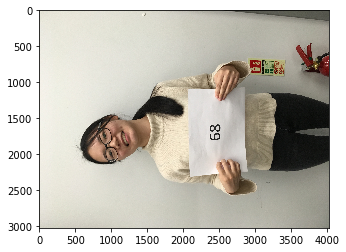

In [55]:
# open image in new window
# pim.show() #open image in new window
plt.imshow(pim) # show using matplotlib

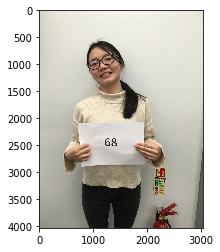

In [56]:
# We add this helper function to the load image function to account for the iPhone SE quirk
if str(pim.info['exif']).find('iPhone SE') != -1:
    rotateim = pim.rotate(-90,expand=1)
    plt.imshow(rotateim)
else:
    plt.imshow(pim)

-------
This concludes our data selection and extraction. Next step train the algorithms on "much face"

# Additional dataset much face plus that includes unknown individuals 
Added at later stage as additional coursework requirement were published 

In [4]:
unknown_faces_path = data_path.joinpath('unknown_faces')
unknown_train_path = unknown_faces_path.joinpath('train')
unknown_valid_path = unknown_faces_path.joinpath('val') # create valid folder
unknown_valid_path.mkdir(exist_ok=True, parents=True) 

for folder in unknown_train_path.iterdir():
    if str(folder).split('.')[-1] == 'DS_Store':  # ignore mac os DS_Store file
        pass
    else:
        outputsubfolder = str(folder.absolute()).split('/')[-1]
        outputpath = unknown_valid_path.joinpath(outputsubfolder)
        outputpath.mkdir(exist_ok=True, parents=True) # create new output path 
        all_files_list = list(folder.glob('*.jpg'))
        random.shuffle(all_files_list) # randomly shuffle the files
        len_all_files = len(all_files_list)
        n_valid_files = int(len_all_files*0.2) # create 80/20 train/validation split
        selected_files = [all_files_list[i] for i in range(n_valid_files)]
        for file in selected_files:
            move_file_to_valid(file,outputpath)


In [12]:
# copy much_face to much_face_plus
!cp -R data/much_face data/much_face_plus

In [13]:
# copy train 
!cp -R data/unknown_faces/train/ data/much_face_plus/train

In [14]:
# copy val
!cp -R data/unknown_faces/val data/much_face_plus/val